In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [5]:
# Load 10 million rows (adjust as your RAM allows)

df = pd.read_csv('/content/earthquake.csv')
print(df.shape)
df.head()


(23412, 21)


,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [6]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')


In [7]:
df = df.dropna(subset=['DateTime'])


In [8]:
columns_to_drop = ['ID', 'Source', 'Location Source',
                   'Magnitude Source', 'Status',
                   'Magnitude Type', 'Type']

df = df.drop(columns=columns_to_drop, errors='ignore')


In [9]:
print(df.isnull().sum())


Date                              0
Time                              0
Latitude                          0
Longitude                         0
Depth                             0
Depth Error                   18949
Depth Seismic Stations        16313
Magnitude                         0
Magnitude Error               23082
Magnitude Seismic Stations    20845
Azimuthal Gap                 16111
Horizontal Distance           21805
Horizontal Error              22253
Root Mean Square               6059
DateTime                          0
dtype: int64


In [10]:
df['Depth'] = df['Depth'].fillna(df['Depth'].mean())


In [11]:
def categorize_magnitude(mag):
    if mag < 5:
        return 'Minor'
    elif mag < 6:
        return 'Moderate'
    elif mag < 7:
        return 'Strong'
    else:
        return 'Major'

df['MagClass'] = df['Magnitude'].apply(categorize_magnitude)


In [12]:
print(df['MagClass'].value_counts())


MagClass
Moderate    16055
Strong       6616
Major         738
Name: count, dtype: int64


In [13]:
df['Month'] = df['DateTime'].dt.month


In [14]:
features = ['Latitude', 'Longitude', 'Depth', 'Month']
X = df[features]


In [15]:
y = df['MagClass']


In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(le.classes_)


['Major' 'Moderate' 'Strong']


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [19]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       Major       0.04      0.01      0.01       158
    Moderate       0.71      0.86      0.78      3238
      Strong       0.36      0.22      0.27      1286

    accuracy                           0.65      4682
   macro avg       0.37      0.36      0.35      4682
weighted avg       0.59      0.65      0.61      4682



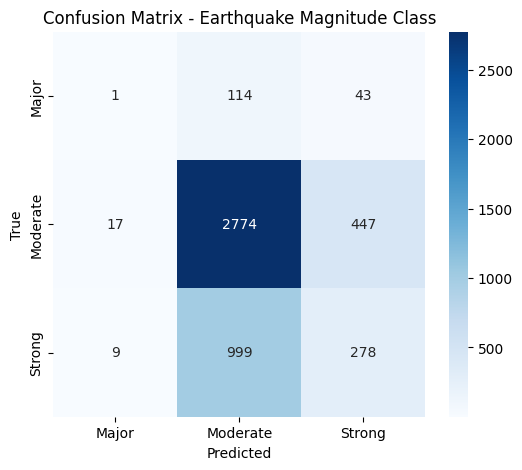

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Earthquake Magnitude Class")
plt.show()


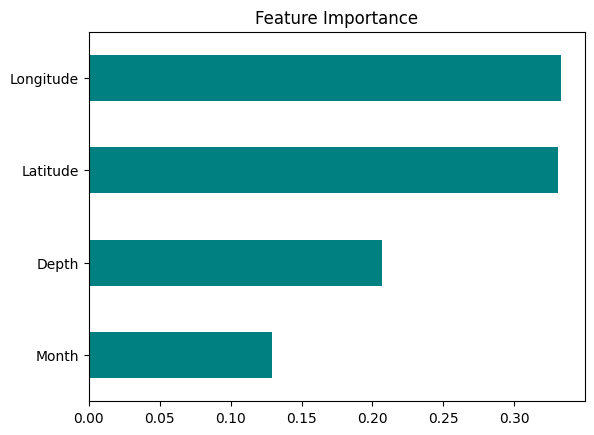

In [21]:
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=features)

feat_importances.sort_values().plot(kind='barh', color='teal')
plt.title("Feature Importance")
plt.show()


In [22]:
import joblib

joblib.dump(model, "earthquake_model.pkl")


['earthquake_model.pkl']

In [23]:
sample = pd.DataFrame({
    'Latitude': [20.0],
    'Longitude': [120.0],
    'Depth': [50.0],
    'Month': [3]
})

pred_class = model.predict(sample)
print("Predicted class:", le.inverse_transform(pred_class))


Predicted class: ['Moderate']
